In [3]:
# See http://www.wikimedecine.fr/Electrocardiogramme_(ECG)_-_%C3%A9l%C3%A9ments_d%27interpr%C3%A9tation

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime, time
from funs import *

import wfdb

In [4]:
sig_wdb, fields_wdb = wfdb.rdsamp('mimic2wdb/matched/s00076/3924340_0004', pbdl=1, dldir='data/mimic2wdb/s00076')
# sig, fields = wfdb.rdsamp('mimic2db/a40104/a40104_000000', pbdl=1, dldir='data')
print(fields_wdb)
# print(fields)
fs_wdb = fields_wdb['fs']
# fs = fields['fs']

File data/mimic2wdb/s00076/3924340_0004.hea is already present.
File data/mimic2wdb/s00076/3924340_0004.dat is already present.
{'nseg': 1, 'nsig': 5, 'fs': 125.0, 'nsamp': 6765000, 'basetime': '18:51:20.648', 'basedate': '', 'filename': ['3924340_0004.dat', '3924340_0004.dat', '3924340_0004.dat', '3924340_0004.dat', '3924340_0004.dat'], 'fmt': ['16', '16', '16', '16', '16'], 'sampsperframe': [1, 1, 1, 1, 1], 'skew': [0, 0, 0, 0, 0], 'byteoffset': [0, 0, 0, 0, 0], 'gain': [1023.0, 1023.0, 512.0, 510.0, 512.0], 'units': ['pm', 'NU', 'mV', 'mV', 'mV'], 'baseline': [0, 0, 255, 256, 255], 'initvalue': [0, 478, 772, -32768, -32768], 'signame': ['RESP', 'PLETH', 'II', 'V', 'AVR'], 'nsampseg': [], 'comments': []}


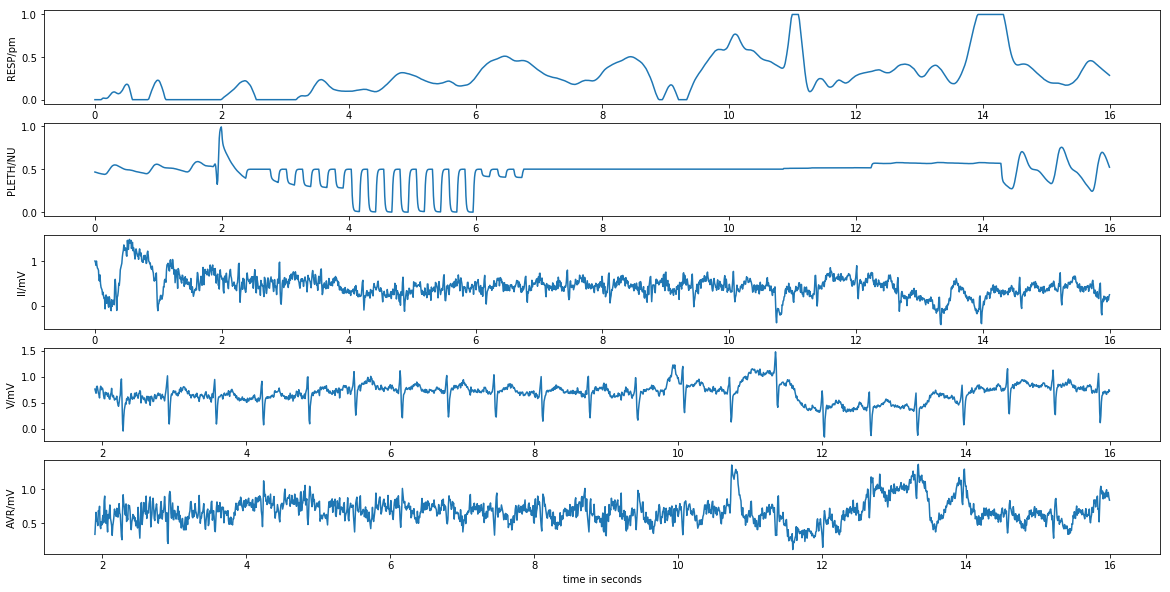

In [7]:
sig1 = sig_wdb[:2000]
myplot(sig1, fields_wdb)

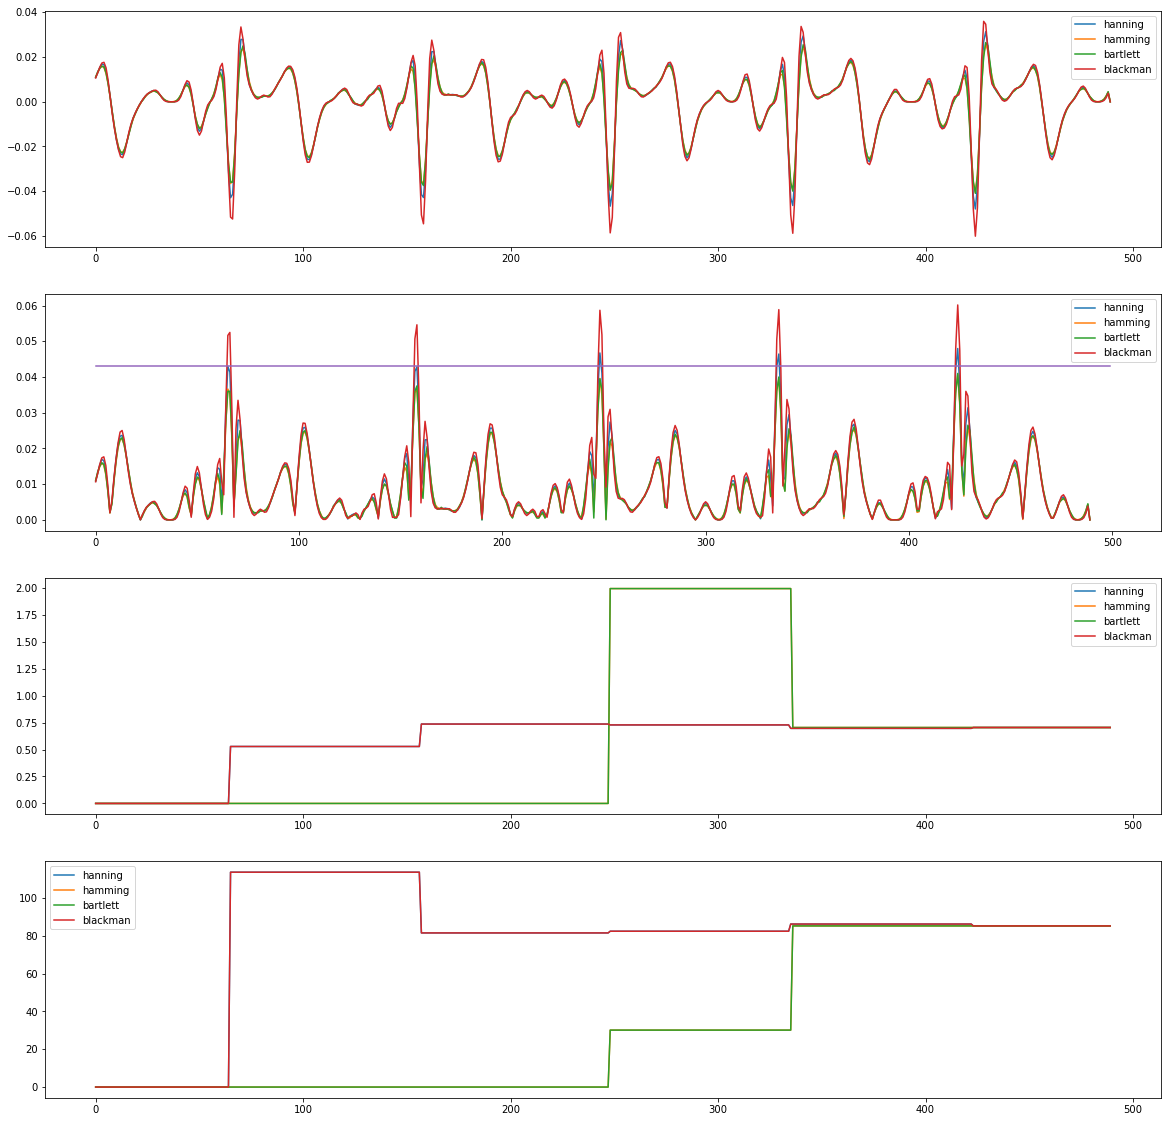

0.0421764152231


In [157]:
def get_rr(sig, window):
    smoothed = smooth(sig, window=window)[10:-10]
    signal_diff = np.diff(smoothed)
    signal_diff = np.append(signal_diff, 0)
    abs_diff = np.sqrt(signal_diff ** 2)
    ecg_threshold = np.average(abs_diff) * 4.5

    count = 0
    last_val = .0
    current_rr = .0
    current_rate = .0

    rr_intervals_array = []
    rr_intervals_rate = []

    for k, val in enumerate(abs_diff):
        count = count + 1
        if (val > ecg_threshold and last_val < ecg_threshold):
            current_rr = count / (fields['fs'])
            current_rate = 60.0 / current_rr
            count = 0
        last_val = val
        rr_intervals_array.append(current_rr)
        rr_intervals_rate.append(current_rate if current_rate < 220 else 0)

    return signal_diff, abs_diff, rr_intervals_array, rr_intervals_rate, ecg_threshold

def plot_rr2(sig, signal_diff, abs_diff, rr_intervals_array, rr_intervals_rate, ecg_threshold):
    fig, ax = plt.subplots(4, figsize=(20, 20))
    ax[0].plot(signal_diff)
    ax[1].plot(abs_diff)
    ax[1].plot([0, len(sig)-1], [ecg_threshold, ecg_threshold])
    ax[2].plot(rr_intervals_array, '.')
    ax[3].plot(rr_intervals_rate)
    plt.show()

def plot_rr(sig, window):
    plot_rr2(sig, *get_rr(sig, window))

# windows = ['hanning', 'hamming', 'bartlett', 'blackman']

# fig, ax = plt.subplots(4, figsize=(20, 20))
# for window in windows:
#     sd, ad, rra, rrr, ecg = get_rr(sig1[:, 0], window)
#     ax[0].plot(sd, label=window)
#     ax[1].plot(ad, label=window)
#     ax[2].plot(rra, label=window)
#     ax[3].plot(rrr, label=window)
    
# ax[1].plot([0, len(sig1[:, 0])-1], [ecg, ecg])
# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
# ax[3].legend()
# fig.savefig('rr_different_windows.png', dpi=300)
# plt.show()

In [164]:
list(reversed(range(0, 10)))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

(6765000, 5)
MWI size: 10


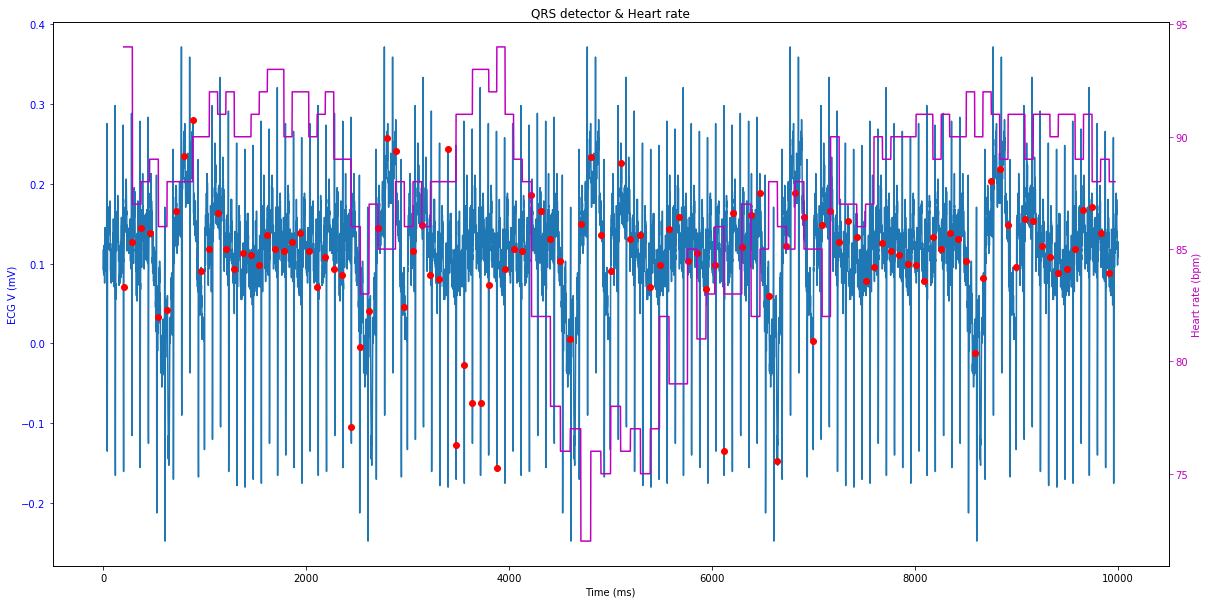

In [269]:
from dsfaker.generators import *
from queue import Queue


# Pan Tompkins real-time QRS detector
#   Steps: ECG -> Filters -> Derivation -> Squaring function -> Integration -> Adjusting thresholds -> Decision -> Result

class CircularBuffer(Generator):
    def __init__(self, size, initial_values=None):
        self.size = size
        if initial_values is None:
            self.buff = numpy.zeros(size, dtype=numpy.float64)
        else:
            assert size == len(initial_values)
            self.buff = numpy.asarray(initial_values)
        self.idx = 0
    
    def put(self, value):
        if self.idx == self.size:
            self.idx = 0
        self.buff[self.idx] = value
        self.idx += 1
    
    def get_prev(self, i):
        return self.buff[(self.size + self.idx + i) % self.size]
    
    def get_single(self, new_val):
        self.put(new_val)
        return new_val
    
    def get_batch(self, batch_size, new_vals):
        for e in new_vals:
            self.put(e)
        return vals
    
    def get_mean(self):
        return numpy.sum(self.buff) / self.size
        

class History(Generator):
    def __init__(self, generator, size, initial_values=None):
        self.cb = CircularBuffer(size, initial_values)
        self.generator = generator
        self.size = size
    
    def get_prev(self, i):
        return self.cb.get_prev(i)
    
    def get_single(self) -> float:
        return self.cb.get_single(self.generator.get_single())
        
    def get_batch(self, batch_size: int) -> numpy.array:
        return self.cb.get_batch(batch_size=batch_size, new_vals=self.generator.get_batch(batch_size))
        
    def get_mean(self):
        return self.cb.get_mean()

    
# class Splitter(Generator):
#     def __init__(self, generator, nb_splits):
#         self.generator = generator
#         self.nb_splits = nb_splits
#         self.idx = 0
#         self.current_val = None
    
#     def 
    
#     def get_single(self):
        
        

class LowPass(Generator):
    def __init__(self, generator):
        self.x = History(generator, 12)
        self.old2 = 0
        self.old1 = 0
        self.delay = 6 + (generator.delay if hasattr(generator, 'delay') else 0)
    
    def get_single(self):
        xn6 = self.x.get_prev(-6)
        xn12 = self.x.get_prev(-12)
        xn = self.x.get_single()
        res = 2 * self.old1 - self.old2 + xn - 2 * xn6 + xn12
        self.old2 = self.old1
        self.old1 = res
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class HighPass(Generator):
    def __init__(self, generator):
        self.x = History(generator, 32)
        self.old1 = 0
        self.delay = 16 + (generator.delay if hasattr(generator, 'delay') else 0)
    
    def get_single(self):
        xn16 = self.x.get_prev(-16)
        xn32 = self.x.get_prev(-32)
        xn = self.x.get_single()
        res = 32 * xn16 - (self.old1 + xn - xn32)
        self.old1 = res
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)


class Differentiator(Generator):
    def __init__(self, generator):
        self.x = History(generator, 5)
        self.delay = 2 + (generator.delay if hasattr(generator, 'delay') else 0)
        self.get_single()
        self.get_single()
    
    def get_single(self):
        xnl2 = self.x.get_prev(-4)
        xnl1 = self.x.get_prev(-3)
        xnp1 = self.x.get_prev(-2)
        xnp2 = self.x.get_prev(-1)
        self.x.get_single()
        return 1.0/8.0 * (-xnl2 -2*xnl1 + 2*xnp1 + xnp2)
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class MovingWindowIntegration(Generator):
    def __init__(self, generator, size):
        self.x = History(generator, size)
        self.delay = generator.delay if hasattr(generator, 'delay') else 0
    
    def get_single(self):
        res = self.x.get_mean()
        self.x.get_single()
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class RR(Generator):
    def __init__(self, generator, frequency):
        self.generator = generator
        self.fs = frequency
        self.count = 0
        self.last_val = .0
        self.current_rr = .0
        self.current_rate = .0
    
    def get_single(self):
        threshold = 10
        val = self.generator.get_single()
        self.count += 1
        if val > threshold and self.last_val < threshold:
            self.current_rr = self.count / self.fs
            self.current_rate = 60.0 / self.current_rr
            self.count = 0
        self.last_val = val
        return self.current_rate
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

RR_LOWEST  =  170 # ms -> Lowest  interval between two Rpeaks (352bpm)
RR_MEAN = 600 # ms
RR_HIGHEST = 2000 # ms -> Highest interval between two Rpeaks ( 30bpm)
RR_MISSED  = 3000 # ms -> Interval for which we consider that we missed a Rpeak (20bpm)

PEAK_THRESHOLD1 = 30 # MWI minimum value
PEAK_THRESHOLD2 = 0.5 * PEAK_THRESHOLD1

MAX_MISS = 5
L_MUL = 0.92
H_MUL = 1.16
M_MUL = 1.66
    
class QRS(Generator):
    def __init__(self, generator, frequency):
        self.generator = generator
        self.delay = 1 + generator.delay if hasattr(generator, 'delay') else 0
        self.fs = frequency
        
        self.peak_val = 0
        self.spk = 40
        self.npk = 15
        self.interval = 10000 # Interval since last Rpeak
        self.miss = 0
        self.RR_Average2 = RR_MEAN
        
        # Thresholds
        self.RR_LOWEST = RR_LOWEST
        self.RR_HIGHEST = RR_HIGHEST
        self.RR_MISSED = RR_MISSED
        self.THRESH1 = PEAK_THRESHOLD1
        self.THRESH2 = PEAK_THRESHOLD2
        
        # History
        self.prev_vals  = CircularBuffer(3)   # The last 3 values
        self.prev_peaks_since_last_R = []
        self.prev_RR    = CircularBuffer(8, numpy.full(8, 100))   # The last 8 intervals between Rpeaks
        self.prev_RRok  = CircularBuffer(8, numpy.full(8, RR_MEAN))   # The last 8 intervals between valid Rpeaks
        
        self.c = 0
        self.current_hr = numpy.nan
    
    def _is_peak(self):
        # FIXME
        vl1 = self.prev_vals.get_prev(-3)
        v0 = self.prev_vals.get_prev(-2)
        vp1 = self.prev_vals.get_prev(-1)
#         print(vl1, v0, vp1, self.val_i.idx, vl1 < v0 and v0 > vp1)
        return vl1 < v0 and v0 > vp1, v0
    
    def _update_thresholds(self, v):
        self.spk = int(0.125 * v + 0.875 * self.spk)
        self.RR_Average2 = self.prev_RRok.get_mean()

        self.RR_LOWEST  = max(int(L_MUL * self.RR_Average2), RR_LOWEST)
        self.RR_HIGHEST = min((H_MUL * self.RR_Average2), RR_HIGHEST)
        self.RR_MISSED  = min(int(M_MUL * self.RR_Average2), RR_MISSED)

        self.THRESH1 = int(self.npk + 0.25 * (self.spk - self.npk))
        self.THRESH2 = int(0.5 * self.THRESH1)
    
    def get_single(self):
        val_i = self.generator.get_single()
        self.prev_vals.put(val_i)
        
        is_peak, v0 = self._is_peak() # v0 is the peak value
        
        detected = 0
        irregular_heartrate = 0
        
        RR = self.interval * (1.0 / self.fs) * 1000 # milliseconds since last Rpeak
        
        if RR >= self.RR_MISSED:
            self.miss += 1
            # We probably missed a peak, let's scroll back in time and find the missing peak...
            found = False
            nb_peaks = len(self.prev_peaks_since_last_R)
            for j in reversed(range(nb_peaks)):
                vx, ix = self.prev_peaks_since_last_R[j]
                if vx > self.THRESH2:
#                     print('Missed:', self.c, self.RR_Average2, self.RR_LOWEST, RR, self.RR_HIGHEST)
                    self.prev_peaks_since_last_R = self.prev_peaks_since_last_R[j+1:] if j+1 < nb_peaks else []
                    found = True
                    self.interval -= ix
                    RR = self.interval * (1.0 / self.fs) * 1000
                    self.prev_RR.put(RR)
                    self._update_thresholds(vx)
                    self.c += 1
                    break
            if not found:
                pass
#                 print('Missed peak not found! Irregular heart rate?')
        
        if is_peak:
            # We found a peak, let's check if it is a Rpeak or not...
            
            if v0 >= self.THRESH1:
                if self.RR_LOWEST <= RR and RR <= self.RR_HIGHEST:
                    # It is a valid Rpeak!
#                     print('1:', self.c, self.RR_Average2, self.RR_LOWEST, RR, self.RR_HIGHEST)
                    self.prev_peaks_since_last_R = []
                    irregular_heartrate = 0
                    self.interval = 0
                    self.miss = 0
                    
                    self.prev_RR.put(RR)
                    self.prev_RRok.put(RR)

                    self._update_thresholds(v0)
                    
                    detected = 1
                    self.c += 1
                    
            if detected == 0:
                # It is a noise peak
                self.prev_peaks_since_last_R.append((v0, self.interval))
                self.npk = int(0.125 * v0 + 0.875 * self.npk)
                self.THRESH1 = int(self.npk + 0.25 * (self.spk - self.npk))
                self.THRESH2 = int(0.5 * self.THRESH1)
        
        if self.c > 2:
            self.current_hr = 60000.0 / self.prev_RR.get_prev(-1)
        
        if self.miss >= MAX_MISS:
            irregular_heartrate = 1
        
        self.interval += 1
        
        return detected, self.current_hr

    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

        

    
#######################
# QRS complex detection

# i = output signal of the MWI
# f = output signal of the band-pass filter

# A peak is a local maximum determined by observing when the signal changes direction within a predefined time interval.
# PEAK_{i,f} = overall peak
# SPK_{i,f}  = the running estimate of the signal peak (it is an identified QRS complex)
# NPK_{i,f}  = the running estimate of the noise peak (it is any peak not related to the QRS complex (such as T-wave))
# THRESHOLD1_{i,f} = the first threshold applied
# THRESHOLD2_{i,f} = the second threshold applied (when QRS was not detected by THRESHOLD1)

# SPK_{i,f}_current = 0.125 PEAK_{i,f}_current + 0.875 SPK_{i,f}_previous
# NPK_{i,f}_current = 0.125 PEAK_{i,f}_current + 0.875 NPK_{i,f}_previous

# THRESHOLD1_{i,f} = NPK_{i,f} + 0.25 (SPK_{i,f} - NPK_{i,f})
# THRESHOLD2_{i,f} = 0.5 THRESHOLD1_{i,f}
#######################
    
    
print(sig_wdb.shape)
size = 10000
sig1 = sig_wdb[35000:, 3]
fss = fs_wdb

data_gen = (RepeatPattern(sig1[:size])-0.5)/2.0

# Band-pass filter
lp_gen = LowPass(data_gen) # Low-pass filter
hp_gen = HighPass(lp_gen) # High-pass filter

# Derivation
diff_gen = Differentiator(hp_gen)

# Squaring
sq_gen = diff_gen ** 2

# Moving Window Integration
mwi_width = 80 #ms
mwi_size = int((mwi_width/1000)*fss)
print('MWI size: {}'.format(mwi_size))
mwi_gen = MovingWindowIntegration(sq_gen, mwi_size)

# QRS detector
qrs_gen = QRS(mwi_gen, fss)

# fig, ax = plt.subplots(8, figsize=(20, 40))
# ax[0].plot(data_gen.get_batch(size))
# ax[0].set_title('Original signal')

# ax[1].plot(hp_gen.get_batch(size))
# ax[1].set_title('Filtered signal')

# ax[2].plot((data_gen*530).get_batch(size), label='Original')
# ax[2].plot(hp_gen.get_batch(size)[hp_delay:], label='Filtered')
# ax[2].set_title('Original with filtered signal')

# ax[3].plot(diff_gen.get_batch(size))
# ax[3].set_title('Differentiated signal')

# ax[4].plot(sq_gen.get_batch(size))
# ax[4].set_title('Squared signal')

# ax[5].plot(mwi_gen.get_batch(size))
# ax[5].set_title('MWI signal')

# ax[6].plot(((data_gen)*50).get_batch(size))
# ax[6].plot(mwi_gen.get_batch(size)[hp_delay+int(mwi_size/2):])
# ax[6].set_title('Original with MWI signal')

# ax[7].plot(rr_gen.get_batch(size)[hp_delay:])

# y1 = range(size)
# x1 = []
# y2 = []
# x2 = []
# for k in range(size):
#     d = data_gen_bis.get_single()
#     x1.append(d)
#     if qrs_gen.get_single() == 1:
#         x2.append(x1[-25])
#         y2.append(k-25)

# ax[7].plot(y1, x1, label='Original signal')
# ax[7].plot(y2, x2, 'ro', label='Rpeak')
# ax[7].set_title('QRS detector')
    
# data = data_gen_bis.get_batch(size)
# qrs = qrs_gen.get_batch(size)[qrs_gen.delay]

# ax[7].plot(data_gen_bis.get_batch(size))
# ax[7].plot(qrs_gen.get_batch(size)[hp_delay+1:])
# ax[7].set_title('RR signal')

# ax[8].plot(qrs_gen.get_batch(size)[1:])
# ax[8].plot((mwi_gen_bis/40.0).get_batch(size))
# ax[8].set_title('QRS signal')


x_sig = range(size)
y_sig = []
x_rpeak = []
y_rpeak = []
x_hr = []
y_hr = []
for k in range(size):
    v = data_gen_bis.get_single()
    d, hr = qrs_gen.get_single()
    y_sig.append(v)
    if not numpy.isnan(hr):
        x_hr.append(k-28)
        y_hr.append(int(hr))
    if d == 1:
        y_rpeak.append(y_sig[-28])
        x_rpeak.append(k-28)

fig, ax_left = plt.subplots(figsize=(20, 10))
ax_right = ax_left.twinx()

ax_left.plot(x_sig, y_sig, label='Original signal')
ax_left.plot(x_rpeak, y_rpeak, 'ro', label='Rpeak')
ax_right.plot(x_hr, y_hr, label='Heart rate', color='m')

ax_left.set_title('QRS detector & Heart rate')

ax_left.set_xlabel('Time (ms)')
ax_left.set_ylabel('ECG V (mV)', color='b')
ax_right.set_ylabel('Heart rate (bpm)', color='m')
# Make the y-axis label, ticks and tick labels match the line color.
ax_left.tick_params('y', colors='b')
ax_right.tick_params('y', colors='m')


plt.show()